# QA Chatbot Development: HER2 Clinical Publication

This notebook demonstrates the development and evaluation of a Retrieval-Augmented Generation (RAG) chatbot. The goal is to answer questions about the 1987 Slamon et al. HER2 breast cancer publication using only its contents and an open-source LLM. 

Key components:
- Ingest and preprocess publication text
- Chunk and embed the content
- Perform semantic retrieval using vector similarity
- Generate grounded answers using an LLM
- Evaluate retrieval quality and tune hyperparameters

## 1. Environment Setup

Load libraries, set environment variables, and import local modules. Reload modules as needed during iterative development.

In [10]:
# Import required libraries, configure the environment, and ensure reproducibility.

# Standard library
import importlib
import os

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Local modules
import rag_generator
import rag_retriever

# Reload local modules (for development convenience)
importlib.reload(rag_generator)
importlib.reload(rag_retriever)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 2. Document Ingestion and Chunking

Load the clean transcript of the HER2 publication and convert it into overlapping chunks suitable for embedding and retrieval. Chunking parameters are optimized to balance context and performance.

In [2]:
# Start with a sensible open source model good for QA
model_name="e5"

# Import raw text
text = rag_retriever.ingest_doc()

# Get LangChain documents (chunks)
documents = rag_retriever.get_documents(text, model_name) # save_filename="chunks.csv")

## 3. Vectorstore Construction and Retriever Initialization
Create the vector store using the selected embedding model, then convert it into a retriever for use in the RAG pipeline.

In [ ]:
# Create vectorstore
vectorstore = rag_retriever.get_vectorstore(model_name, documents, collection_name="temp")

# Create retriever
retriever = vectorstore.as_retriever(search_type="similarity")

## 4. Retrieval Evaluation

Evaluate the retriever using a predefined set of clinical questions with known supporting context. Metrics include accuracy, F1, recall@k, and precision@k.

In [ ]:
# Evaluate retriever
results, metrics = rag_retriever.evaluate_retriever(retriever, top_k=3, threshold=None)
pd.DataFrame([metrics])

,accuracy,avg_recall@k,avg_precision@k,avg_f1
0,0.8,0.75,0.5,0.56


## 5. Per-Question Retrieval Analysis

Manually review retrieved context and recall score for each question. This helps validate whether the correct sections of the text are being surfaced.

In [5]:
# To view results per question

for i,q in enumerate(results):
    query = results[i]["question"]
    # answer = eval_set[i]["answer"]
    expected = results[i]["expected"]
    retrieved = results[i]["retrieved"]
    recall = results[i]["recall@k"]
    
    print(f"Query {i}: {query}")
    # print(f"Answer: {answer}")
    print(f"Num Expected: {len(expected)}, Num Retrieved: {len(retrieved)}, recall@k: {recall:.2f}\n")

Query 0: What percentage of tumors showed HER-2/neu amplification?
Num Expected: 3, Num Retrieved: 3, recall@k: 0.67

Query 1: What is the molecular weight of the HER-2/neu protein?
Num Expected: 2, Num Retrieved: 3, recall@k: 1.00

Query 2: How does HER-2/neu copy number relate to survival times?
Num Expected: 3, Num Retrieved: 3, recall@k: 1.00

Query 3: What is the incidence rate of EGFR amplification compared to HER-2/neu?
Num Expected: 2, Num Retrieved: 3, recall@k: 0.50

Query 4: How does HER-2/neu compare to estrogen receptor status in prognosis?
Num Expected: 2, Num Retrieved: 3, recall@k: 1.50

Query 5: What makes HER-2/neu different from EGFR at the molecular level?
Num Expected: 3, Num Retrieved: 3, recall@k: 0.33

Query 6: What method was used to assess gene amplification?
Num Expected: 3, Num Retrieved: 3, recall@k: 0.00

Query 7: How was DNA prepared and visualized in this study?
Num Expected: 2, Num Retrieved: 3, recall@k: 0.50

Query 8: What was the p-value for the corr

## 6. Embedding Model and Hyperparameter Tuning

Systematically evaluate multiple embedding models, top_k values, and retrieval thresholds to identify the optimal configuration for accurate document grounding.

### 6.1. Loop Through Hyperparameters

In [4]:
# Define hyperparameters to search
models = ["e5", "sbert", "pubmedbert", "biobert-sim", "biobert-raw"]
ks = [1, 2, 3, 4, 5, 6, 7]
thresholds = [None, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85]

df = rag_retriever.evaluation_loop(documents, embedding_models=models, ks=ks, thresholds=thresholds)
df["threshold"] = df["threshold"].astype(str)
df.to_csv("tuning_results.csv", index=None)

Embedding Models: 100%|███████████████████████████████████████| 5/5 [01:37<00:00, 19.45s/it]


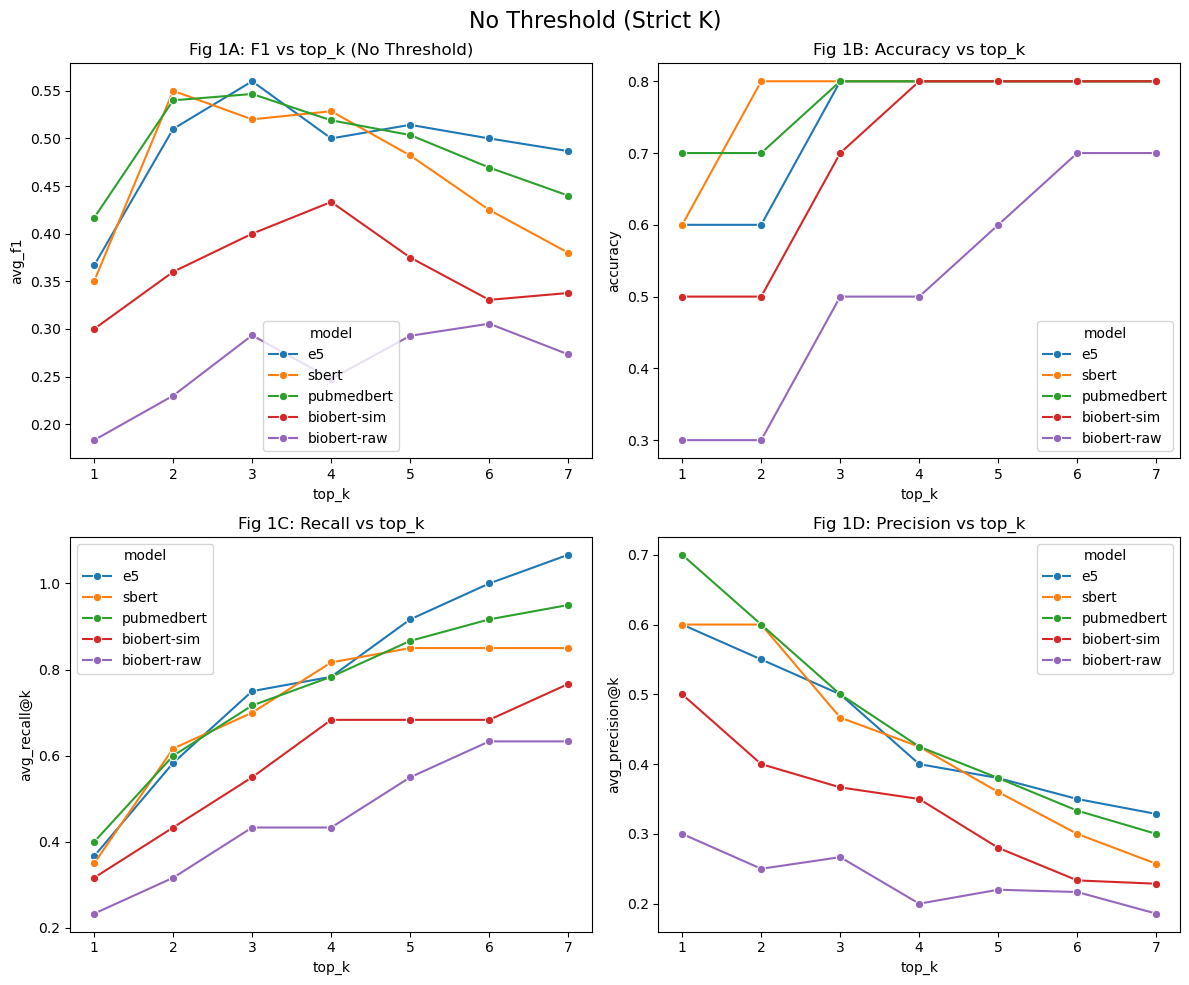

In [5]:
importlib.reload(rag_retriever)
rag_retriever.visualize_retrieval_metrics(df[df.threshold=="None"], title="No Threshold (Strict K)")

**Interpretation:**

Results are visualized with threshold = None, so that metrics are comparable across models. The bioberts didn't perform as well as expected. e5, sbert, and pubmedbert are somewhat equivalent. Accuracy is computed by considering a test question a "hit" if at least one retrieved doc is in the ground truth (gt) dataset. Each item has 2-3 gt chunks. Gt chunks are smaller than embedded chunks, and because of overlapping more than one retrieved chunk may match the same gt chunk. This is why recall, which is defined as #hits / #gts, can be greater than 1. A subsequent analysis was performed, correcting for retrievals that duplicate a given gt (#unique hits/#gts). This corrected recall prioritizes diversity in responses.

### 6.2. Adjusted Recall: Measuring Retrieval Diversity

To address overcounting from overlapping or duplicate chunk matches, we calculate a corrected recall metric. This helps assess not only whether relevant documents are retrieved, but whether they come from distinct parts of the source text.


In [6]:
df_corrected = rag_retriever.evaluation_loop(documents, embedding_models=models, ks=ks, thresholds=thresholds, corrected=True)
df_corrected["threshold"] = df_corrected["threshold"].astype(str)
df_corrected.to_csv("tuning_results_corrected.csv", index=None)

Embedding Models: 100%|███████████████████████████████████████| 5/5 [01:17<00:00, 15.42s/it]


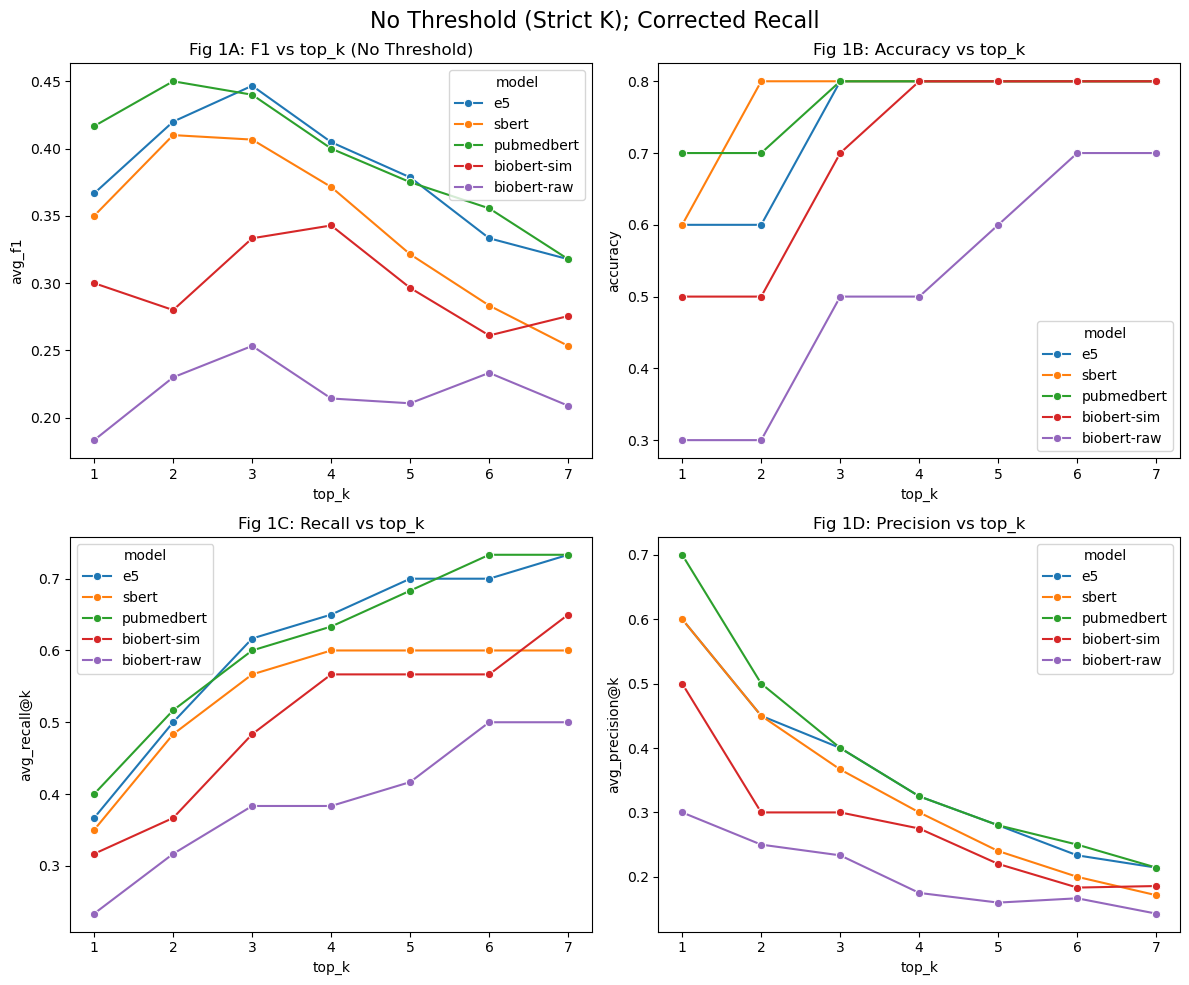

In [7]:
importlib.reload(rag_retriever)
rag_retriever.visualize_retrieval_metrics(df_corrected[df_corrected.threshold=="None"], title="No Threshold (Strict K); Corrected Recall")

**Interpretation**:

Corrected recall reveals which models actually diversify their retrievals. sbert and biobert-sim are surprisingly efficient at doing so.

As expected, all recall values are lower compared to typical recall@k, since duplicate chunk hits no longer count. Still, e5 and pubmedbert remain top performers when considered only unique relevant chunks. e5 delivered the best overall performance at k=3–4, with the highest F1 score and strongest mid-range recall. Pubmedbert excelled at top-1 accuracy and early precision, and showed strong overall recall at higher k values, though it was less efficient in the mid-range due to redundant retrievals. Overall, **e5 at k=3** strikes the best balance between coverage and relevance for clinical QA.


### 6.3. Threshold Optimization at Top-K = 3

Given that k=3 delivered the best balance of recall and precision, we now evaluate the impact of varying the similarity threshold. This helps determine whether setting a minimum confidence level improves retrieval reliability.

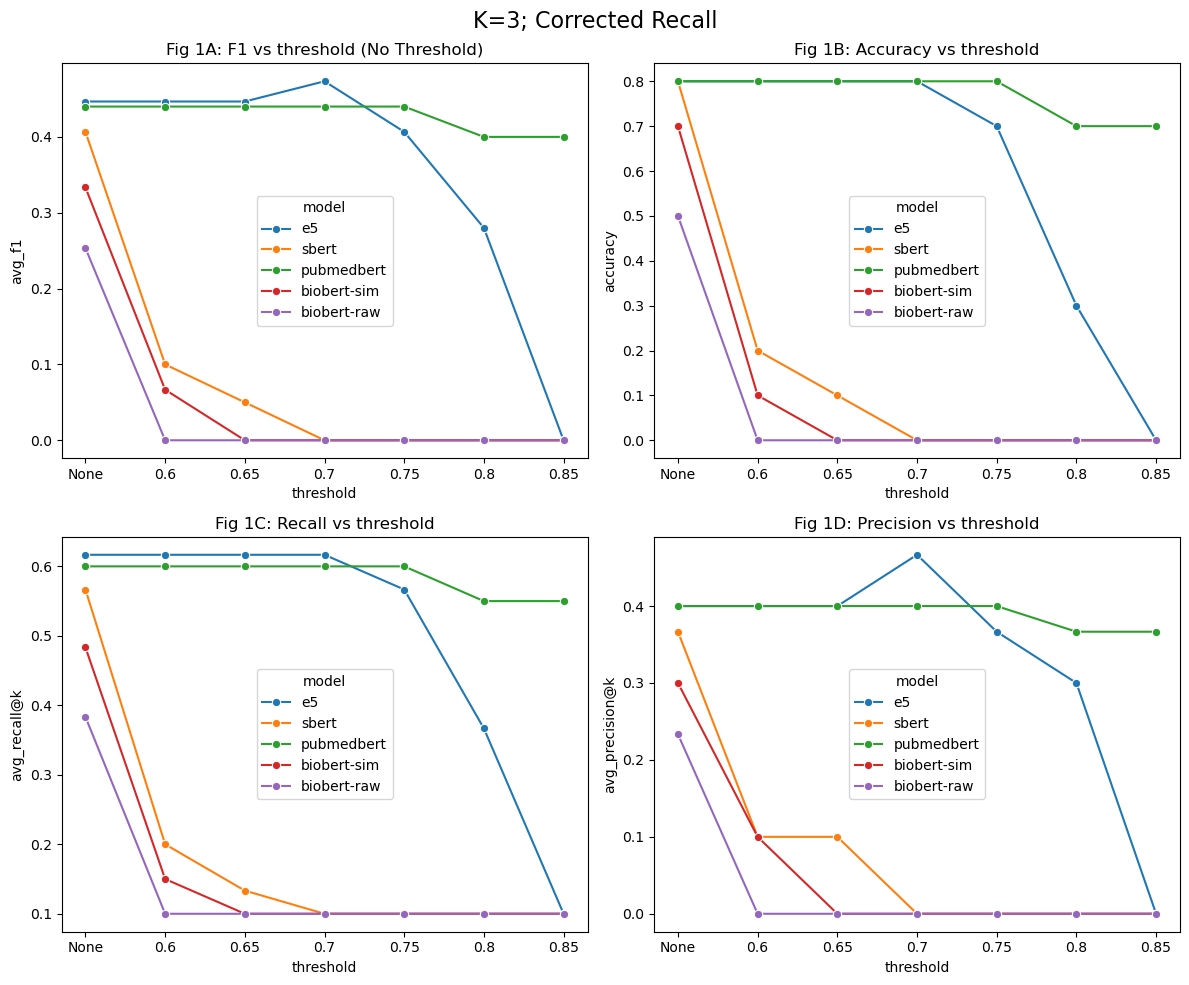

In [8]:
rag_retriever.visualize_retrieval_metrics(df_corrected[df_corrected.top_k==3], x='threshold',
                                          title="K=3; Corrected Recall")

**Interpretation**:

Threshold tuning reveals that pubmedbert is highly robust and capable of filtering aggressively without sacrificing accuracy or recall. e5 benefits from modest thresholding (≤0.7) but deteriorates past that point. Other models degrade rapidly, suggesting they rely more heavily on low-similarity matches to perform well. For high-stakes clinical QA, **pubmedbert @ threshold 0.7 and k=3** is likely the most reliable configuration, but let's turn now to a qualitative analysis.

### 6.4. Hallucination Analysis: Handling No-Answer Scenarios

In this section, we test whether the retrieval pipeline can avoid hallucinations—i.e., confidently generating responses to questions with no relevant support in the document. This is essential for clinical safety and trustworthiness.

In [9]:
def ismatch(retrieved, ground_truths): return any(gt in retrieved or retrieved in gt for gt in ground_truths)

In [10]:
# Evaluate e5
e5_vectorstore = rag_retriever.get_vectorstore("e5", documents, collection_name="temp")
e5_retriever = e5_vectorstore.as_retriever(search_type="similarity")
e5_results, e5_metrics = rag_retriever.evaluate_retriever(e5_retriever, top_k=3, threshold=.70)

In [11]:
for r in e5_results:
    print(f"Expected: {len(r["expected"])} \tRetrieved: {len(r["retrieved"])} \t Hits: {sum(ismatch(chunk, r["expected"]) for chunk in r["retrieved"])}")

Expected: 3 	Retrieved: 3 	 Hits: 2
Expected: 2 	Retrieved: 3 	 Hits: 2
Expected: 3 	Retrieved: 3 	 Hits: 3
Expected: 2 	Retrieved: 3 	 Hits: 1
Expected: 2 	Retrieved: 3 	 Hits: 3
Expected: 3 	Retrieved: 3 	 Hits: 1
Expected: 3 	Retrieved: 3 	 Hits: 0
Expected: 2 	Retrieved: 1 	 Hits: 1
Expected: 2 	Retrieved: 3 	 Hits: 2
Expected: 0 	Retrieved: 0 	 Hits: 0


In [12]:
# Evaluate pubmedbert
pmb_vectorstore = rag_retriever.get_vectorstore("pubmedbert", documents, collection_name="temp")
pmb_retriever = pmb_vectorstore.as_retriever(search_type="similarity")
pmb_results, pmb_metrics = rag_retriever.evaluate_retriever(pmb_retriever, top_k=3, threshold=.70)

In [13]:
for r in pmb_results:
    print(f"Expected: {len(r["expected"])} \tRetrieved: {len(r["retrieved"])} \t Hits: {sum(ismatch(chunk, r["expected"]) for chunk in r["retrieved"])}")

Expected: 3 	Retrieved: 3 	 Hits: 3
Expected: 2 	Retrieved: 3 	 Hits: 2
Expected: 3 	Retrieved: 3 	 Hits: 3
Expected: 2 	Retrieved: 3 	 Hits: 1
Expected: 2 	Retrieved: 3 	 Hits: 1
Expected: 3 	Retrieved: 3 	 Hits: 2
Expected: 3 	Retrieved: 3 	 Hits: 0
Expected: 2 	Retrieved: 3 	 Hits: 1
Expected: 2 	Retrieved: 3 	 Hits: 2
Expected: 0 	Retrieved: 3 	 Hits: 0


**Interpretation**:

The final question tests hallucinations, asking about something that doesn't exist in the document. e5 is shown to be more robust to hallucination on this no-answer query, returning no chunks when no strong matches exists. Pubmedbert, while strong on recall and precision, may surface misleading context unless paired with additional confidence gating.

### 6.5. Final Model Selection and Justification

Based on corrected recall, F1 score, and practical interpretability, the **e5 model at k=3, with threshold=0.07** is selected as the optimal configuration for clinical QA on this publication. It provides strong performance without excessive redundancy and performs well across various threshold settings.

Pubmedbert and e5 were the top-performing models overall. Pubmedbert showed strong accuracy, precision, and recall, especially at a 0.7 threshold. However, in a hallucination test with a no-answer question, e5 correctly returned nothing, while pubmedbert returned unrelated chunks—a potential risk in clinical contexts.

For most use cases, pubmedbert @ k=3, threshold=0.7 offers broad, high-quality retrieval. But for safety-critical settings, e5 @ k=3, threshold=0.7 is recommended due to its more conservative, hallucination-resistant behavior.

## 7. RAG Generator Prototype

Below is a basic end-to-end prototype using the selected retrieval configuration. It retrieves top-matching chunks and generates grounded answers using an LLM. This serves as the foundation for a deployable QA chatbot.

In [ ]:
importlib.reload(rag_generator)
importlib.reload(rag_retriever);

embedder_model_name = "e5"
top_k = 3
threshold = 0.70

text = rag_retriever.ingest_doc()
documents = rag_retriever.get_documents(text, embedder_model_name)

# Get optimal vectorstore and retriever
vectorstore = rag_retriever.get_vectorstore(model_name=embedder_model_name, documents=documents, collection_name="temp")
retriever = vectorstore.as_retriever(search_type="similarity_score_threshold", search_kwargs={"k": top_k, "score_threshold": threshold})

### 7.1 Build RetrievalQA Chain

Uses the `rag_generator.get_qa_chain()` function to create a LangChain pipeline that combines semantic retrieval with response generation.

In [13]:
# Build chain
qa_chain = rag_generator.get_qa_chain(retriever=retriever)

Using Ollama model: mistral


### 7.2. Test the QA Chain

Invoke the QA chain with a test prompt to verify functionality. Replace `q` with a realistic question during actual use.

In [18]:
q = "What is the significance of the HER-2/neu oncogene, and how does it relate to epidermal growth factor receptor?"
answer = qa_chain(q)
print(answer["result"])

 The HER-2/neu oncogene plays a role in the biologic behavior and/or pathogenesis of human breast cancer. It is related to, but distinct from, the epidermal growth factor receptor (EGFR). On the basis of sequence data, HER-2/neu is more closely related to the EGFR gene than to other members of the tyrosine kinase family. Like the EGFR protein, HER-2/neu has an extracellular domain, a transmembrane domain that includes two cysteine-rich repeat clusters, and an intracellular kinase domain, indicating that it too is likely to be a cellular receptor for an as yet unidentified ligand.


In [27]:
q = "What percentage of tumors showed HER-2/neu amplification?"
answer = qa_chain()
print(answer["result"])

30% of the tumors showed HER-2/neu amplification.


## 8. Generator Evaluation: Answer Accuracy and Semantic Alignment

We now evaluate the QA system's generated answers using both manual labels and cosine similarity between generated and ground-truth answers.

### 8.1. Evaluate and Manually Review Responses

Use `evaluate_generator()` to run all evaluation set questions through the QA chain and collect generated answers. Label each generated answer as "hit", "partial", or "miss" based on alignment with the expected response. Save results for future analysis.


In [23]:
qa_results = rag_generator.evaluate_generator(qa_chain)

Evaluating QA chain: 100%|██████████████████████████████████| 10/10 [00:55<00:00,  5.59s/it]


In [24]:
# Manually validate answers
res_df = rag_generator.review_answers(pd.DataFrame(qa_results))
res_df.to_csv("qa_results_with_labels.csv", index=False)

Starting manual review...





**Question 1: What percentage of tumors showed HER-2/neu amplification?**

**Correct Answer:** HER-2/neu was amplified in approximately 30% of the tumors.

**Given Answer:** 30% of the tumors showed HER-2/neu amplification.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 2: What is the molecular weight of the HER-2/neu protein?**

**Correct Answer:** The HER-2/neu protein is 185,000 daltons.

**Given Answer:** 185,000 daltons

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 3: How does HER-2/neu copy number relate to survival times?**

**Correct Answer:** Patients with greater than five copies of HER-2/neu had shorter disease-free and overall survival times.

**Given Answer:** The study shows that an increased copy number of the HER-2/neu gene is associated with shorter disease-free and overall survival times. Specifically, patients with greater than five copies of HER-2/neu had even shorter disease-free survival times (P = 0.015) and overall survival times (P = 0.06) compared to patients with no amplification.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 4: What is the incidence rate of EGFR amplification compared to HER-2/neu?**

**Correct Answer:** EGFR amplification was found in 2% of tumors, whereas HER-2/neu was amplified in about 28–30%, making HER-2/neu amplification 14 times more common.

**Given Answer:** The incidence rate of EGFR amplification is 14 times lower than that of HER-2/neu, as indicated by the study. Specifically, EGFR amplification was found in 4 out of 189 cases (2%), while HER-2/neu amplification was found in 53 out of 189 cases (28%).

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 5: How does HER-2/neu compare to estrogen receptor status in prognosis?**

**Correct Answer:** HER-2/neu amplification had greater prognostic value than estrogen receptor status in lymph node-positive breast cancer.

**Given Answer:** In lymph node-positive disease, amplification of HER-2/neu has greater prognostic value than hormonal-receptor status (such as estrogen receptor).

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 6: What makes HER-2/neu different from EGFR at the molecular level?**

**Correct Answer:** HER-2/neu is located on chromosome 17q21 and encodes a 185 kDa protein, while EGFR is on chromosome 7p11-13 and encodes a 170 kDa protein. Their mRNA sizes also differ.

**Given Answer:** At the molecular level, HER-2/neu differs from EGFR in several ways. Firstly, it is found on band q21 of chromosome 17, while EGFR is located on band p11-p13 of chromosome 7. Secondly, although both proteins have an extracellular domain, a transmembrane domain, and an intracellular kinase domain, HER-2/neu has two cysteine-rich repeat clusters in its transmembrane domain that are not present in EGFR. Lastly, while HER-2/neu is related to EGFR, it is distinct from it within the erbB-like oncogene family.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 7: What method was used to assess gene amplification?**

**Correct Answer:** Southern blot analysis was used to assess gene amplification using radiolabeled HER-2/neu probes.

**Given Answer:** The study used dilution analysis and soft laser densitometry scanning to assess gene amplification of HER-2/neu in the samples.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  p


**Question 8: How was DNA prepared and visualized in this study?**

**Correct Answer:** DNA was digested with Eco RI, run on agarose gels, transferred to nylon filters, and hybridized with radiolabeled probes for autoradiography.

**Given Answer:** In this study, DNA was prepared from individual tumors as described, digested with Eco RI enzyme, and subjected to Southern blot analysis. The DNA was then visualized by hybridizing it with a 32P-labeled HER-2/neu probe and a 32P-labeled arginase gene probe for normalization purposes.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 9: What was the p-value for the correlation between HER-2/neu amplification and relapse?**

**Correct Answer:** The correlation between HER-2/neu amplification and time to relapse was highly significant, with a p-value of <0.0001.

**Given Answer:** The study provides a P value of <0.0001 for the correlation between HER-2/neu amplification and time to disease relapse.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


**Question 10: Does this paper discuss treatment using Herceptin?**

**Correct Answer:** No, the paper does not mention Herceptin.

**Given Answer:** I'm only able to answer questions related to the HER2 study. Please ask me specific questions about that document. This paper does not discuss treatment using Herceptin.

Mark as (h)it, (m)iss, (p)artial, (s)kip, (q)uit:  h


Manual review complete.


### 8.2. Visualize Generator Performance

Visualize accuracy breakdown and similarity scores to assess the relationship between answer quality and semantic similarity.

(Partial hit sorted index: 3)


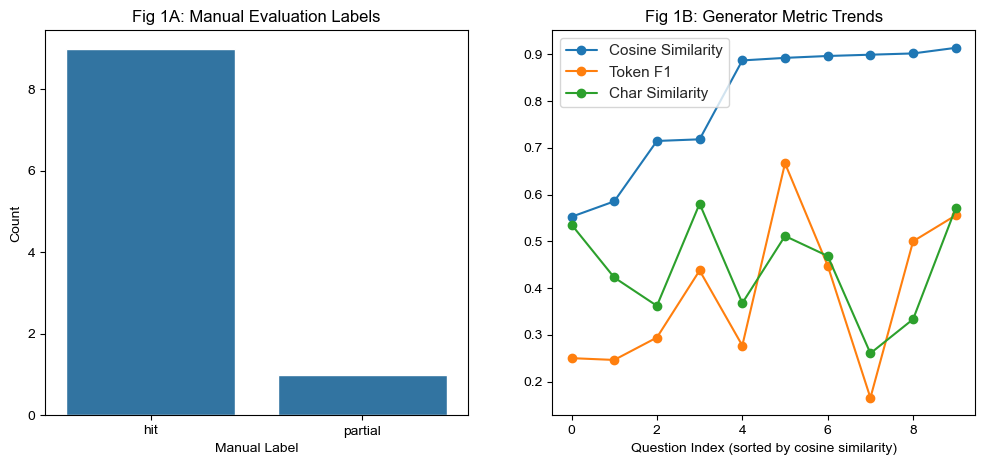

In [25]:
# res_df = pd.read_csv("qa_results_with_labels.csv", index_col=None)
rag_generator.visualize_generator_metrics(res_df)

In [26]:
res_df

,question,given_answer,correct_answer,token_f1,char_similarity,cosine_similarity,manual_label
0,What percentage of tumors showed HER-2/neu amp...,30% of the tumors showed HER-2/neu amplification.,HER-2/neu was amplified in approximately 30% o...,0.500000,0.333333,0.901815,hit
1,What is the molecular weight of the HER-2/neu ...,"185,000 daltons","The HER-2/neu protein is 185,000 daltons.",0.250000,0.535714,0.552401,hit
2,How does HER-2/neu copy number relate to survi...,The study shows that an increased copy number ...,Patients with greater than five copies of HER-...,0.447761,0.468468,0.896351,hit
3,What is the incidence rate of EGFR amplificati...,The incidence rate of EGFR amplification is 14...,"EGFR amplification was found in 2% of tumors, ...",0.276923,0.367758,0.886868,hit
4,How does HER-2/neu compare to estrogen recepto...,"In lymph node-positive disease, amplification ...",HER-2/neu amplification had greater prognostic...,0.666667,0.511278,0.892343,hit
5,What makes HER-2/neu different from EGFR at th...,"At the molecular level, HER-2/neu differs from...",HER-2/neu is located on chromosome 17q21 and e...,0.165138,0.260355,0.899122,hit
6,What method was used to assess gene amplificat...,The study used dilution analysis and soft lase...,Southern blot analysis was used to assess gene...,0.437500,0.580357,0.718097,partial
7,How was DNA prepared and visualized in this st...,"In this study, DNA was prepared from individua...","DNA was digested with Eco RI, run on agarose g...",0.246154,0.422535,0.585383,hit
8,What was the p-value for the correlation betwe...,The study provides a P value of <0.0001 for th...,The correlation between HER-2/neu amplificatio...,0.555556,0.571429,0.913841,hit
9,Does this paper discuss treatment using Hercep...,I'm only able to answer questions related to t...,"No, the paper does not mention Herceptin.",0.294118,0.361905,0.714574,hit


**Interpretation**:

The majority of model-generated answers were manually labeled as correct ("hit"), with only one labeled as "partial" and none as outright misses. This suggests strong alignment between generated answers and expected ground truth responses.

In the right panel, we see cosine similarity scores are consistently high, especially for answers judged as correct. The one "partial" hit (idx 1) aligns with somewaht lower cosine similarity score, confirming the value of semantic similarity as a reliable proxy for answer quality.

Together, these results support the conclusion that the generator is producing accurate, well-grounded responses, with automatic metrics closely tracking human judgment.

## 9. Miscellaneous QA Testing

Below are ad hoc questions asked to test model behavior on greetings, unsupported topics, and generic or ambiguous queries. This includes boundary testing for hallucinations and robustness.

In [36]:
answer = qa_chain("What percentage of tumors showed HER-2/neu amplification?")
print(answer["result"])

30% of the tumors showed HER-2/neu amplification.


### 9.1. Edge Case and Out-of-Scope Questions

Test model responses to conversational prompts ("Hello") and off-topic clinical references ("Herceptin") not present in the original 1987 study.

In [32]:
answer = qa_chain("Hello.")
print(answer["result"])

No relevant docs were retrieved using the relevance score threshold 0.7


 I'm only able to answer questions related to the HER2 study. Please ask me specific questions about that document.

For example, you could ask: "What percentage of the tumors in the study had amplification of the HER-2/neu gene?" or "Was there a correlation between HER-2/neu amplification and hormonal-receptor status?"


In [33]:
q="Does this paper discuss treatment using Herceptin?"
answer = qa_chain(q)
print(answer["result"])

 I'm only able to answer questions related to the HER2 study. Please ask me specific questions about that document. This paper does not discuss treatment using Herceptin.


In [34]:
q="What is the relevance of Herceptin, according to this paper?"
answer = qa_chain(q)
print(answer["result"])

 I'm only able to answer questions related to the HER2 study. Please ask me specific questions about that document.

Herceptin (trastuzumab) is not directly mentioned in the provided document. However, it is a monoclonal antibody directed against the HER-2/neu oncogene product and has been developed for the treatment of breast cancer based on its overexpression in certain tumors. The study suggests that amplification of the HER-2/neu gene may play a role in the biologic behavior and/or pathogenesis of human breast cancer, which could potentially be targeted by therapies like Herceptin.


### 9.2. Generalization and Summary Behavior

Assess whether the model can correctly identify missing information or summarize broad themes, including:
- Abstract questions ("What is this paper about?")
- Author recognition
- Subject inference (e.g., tobacco questions, which should return "not found")


In [39]:
answer = qa_chain("What is this paper about?")
print(answer["result"])

No relevant docs were retrieved using the relevance score threshold 0.7


 This paper investigates the correlation between relapse and survival in patients with breast cancer, and amplification of the HER-2/neu oncogene. The study found that amplification of the HER-2/neu gene was a significant predictor of both overall survival and time to relapse in patients with breast cancer.


In [40]:
answer = qa_chain("Who are the authors of this paper?")
print(answer["result"])

No relevant docs were retrieved using the relevance score threshold 0.7


 The authors of this paper are Dennis J. Slamon, Gary M. Clark, Steven G. Wong, Wendy J. Levin, Axel Ullrich, and William L. McGuire.


In [37]:
answer = qa_chain("What is the relationship between tobacco and lung cancer?")
print(answer["result"])

 I'm only able to answer questions related to the HER2 study. Please ask me specific questions about that document.

The study does not provide information on the relationship between tobacco and lung cancer.


In [41]:
answer = qa_chain("Summarize this paper")
print(answer["result"])

No relevant docs were retrieved using the relevance score threshold 0.7


 The study investigates the correlation between the amplification of the HER-2/neu oncogene, a member of the erbB-like oncogene family, and the survival and relapse of human breast cancer. The researchers found that 30% of the 189 primary human breast cancers had amplifications ranging from 2- to greater than 20-fold. Amplification of the HER-2/neu gene was a significant predictor of both overall survival and time to relapse in patients with breast cancer, even when adjustments were made for other known prognostic factors. The study suggests that this gene may play a role in the biologic behavior and/or pathogenesis of human breast cancer.


In [42]:
answer = qa_chain("Where did this study found test subjects?")
print(answer["result"])

 The study found its test subjects at the University of Texas, San Antonio.


In [44]:
qa_chain("What is the a correlation between HER-2/neu amplification and hormonal-receptor status?")

{'result': ' The study does not provide information on a direct correlation between HER-2/neu amplification and hormonal-receptor status. However, it indicates that HER-2/neu amplification had greater prognostic value than hormonal-receptor status in lymph node-positive disease.'}

# Final Notes and Next Steps

This notebook demonstrates a reproducible development workflow for a RAG chatbot on a scientific paper. Future improvements could include:
- Multi-document support
- On-the-fly OCR reading with support for Figures and Tables
- Using domain experts to generate and evaluate test questions and answers
- Using domain-specific embedding models like CKE
- Better support for bad questions (current model may fails catastrophically when given an unrelated question).

## Conclusion

The chatbot demonstrates a viable RAG framework with consistent grounding, relatively low hallucination risk, and accurate answers to a variety of question types.